# Pathrise Fellows Placement Prediction

The Project is divided into Two parts:

1) In the first part, Model will be built to predict whether a fellow gets placed or not.

I will focus on fellows who got placed or withdrew (either due to not being active/ other reasons or because they could not find a job after one year of going through the program).

(A) Here EDA will be performed

(B) Machine Learning models will be built based on the above data, after multiple iterations, best model will be decided

This analysis will serve as a training model. Most importantly, it will help us identify the most critical factors instrumental in a fellow getting placed or a fellow failing

(C) After model is decided it will be tested on the unseen data - fellows who are currently active:

The reason for excluding other fellows with different pathrise status from the first part of the analysis is - Most of them are currently active but have not been placed.  Including them under "withdrew(failed)"  category would be incorrect as some of them have joined pathrise only a few months back, as long as they are in the program for under a year, they still have a chance of getting a job. That is why they would come under the second part of the project, where analysis from the first part would be applied to test and predict which of the current Pathrise fellows will be placed and how much time it would take. 

2) In the first part, Model will be built to predict how much time ( program_duration_days) a fellow needs to get placed

(A) (B) (C) Same steps will be followed just like in part 1

In [373]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #f
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn_pandas import CategoricalImputer
from pandas import DataFrame
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing

pathrise= pd.read_excel(io="data_Pathrise.xlsx")
pathrise.head()

,id,pathrise_status,primary_track,cohort_tag,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race
0,1,Active,SWE,OCT19A,NaN,0,Unemployed,Bachelor's Degree,3-5 months,Hearing back on my applications,3-4 years,Canada Citizen,2.0,900,Male,Non-Hispanic White or Euro-American
1,2,Active,PSO,JAN20A,NaN,0,Unemployed,"Some College, No Degree",3-5 months,Getting past final round interviews,1-2 years,Citizen,6.0,0,Male,Non-Hispanic White or Euro-American
2,3,Closed Lost,Design,AUG19B,0.0,0,Employed Part-Time,Master's Degree,Less than one month,Figuring out which jobs to apply for,Less than one year,Citizen,0.0,0,Male,East Asian or Asian American
3,4,Closed Lost,PSO,AUG19B,0.0,0,Contractor,Bachelor's Degree,Less than one month,Getting past final round interviews,Less than one year,Citizen,5.0,25,Male,Decline to Self Identify
4,5,Placed,SWE,AUG19A,89.0,1,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American


In [374]:
# renaming the column and dropping unecessary columns

pathrise.rename(columns={'employment_status ': 'Employment_status'}, inplace=True)
pathrise=pathrise.drop(['cohort_tag','id'] ,axis=1)

In [375]:
#Now that we have loaded the dataset, lets check the datatype of the columns 

pathrise.dtypes

pathrise_status                 object
primary_track                   object
program_duration_days          float64
placed                           int64
Employment_status               object
highest_level_of_education      object
length_of_job_search            object
biggest_challenge_in_search     object
professional_experience         object
work_authorization_status       object
number_of_interviews           float64
number_of_applications           int64
gender                          object
race                            object
dtype: object

In [376]:
#lets check for missing values

pathrise.isna().sum()

pathrise_status                  0
primary_track                    0
program_duration_days          616
placed                           0
Employment_status              229
highest_level_of_education      58
length_of_job_search            74
biggest_challenge_in_search     24
professional_experience        222
work_authorization_status      284
number_of_interviews           218
number_of_applications           0
gender                         492
race                            18
dtype: int64

There are many missing values, if I had a larger dataset I would have deleted the missing values, but the dataset is pretty small, so removing them won't be a good strategy.

So I decided to impute the missing categorical values. 

In [377]:
#imputing the categorical columns

imputer = CategoricalImputer()
pathrise.race=imputer.fit_transform(pathrise.race)
pathrise.gender=imputer.fit_transform(pathrise.gender)
pathrise.Employment_status  =imputer.fit_transform(pathrise.Employment_status)
pathrise.highest_level_of_education=imputer.fit_transform(pathrise.highest_level_of_education)
pathrise.length_of_job_search=imputer.fit_transform(pathrise.length_of_job_search)
pathrise.biggest_challenge_in_search=imputer.fit_transform(pathrise.biggest_challenge_in_search)
pathrise.professional_experience=imputer.fit_transform(pathrise.professional_experience)
pathrise.work_authorization_status=imputer.fit_transform(pathrise.work_authorization_status)

As mentioned in the start, I have subsetted the data frame to focus on different Pathrise statuses.

In [378]:
#subsetting to focus on only palced and withdrawn

status = ['Placed', 'Withdrawn (Failed)','Withdrawn']
pathrise_1 = pathrise[pathrise.pathrise_status.isin(status)]
pathrise_1['pathrise_status'].replace('Withdrawn (Failed)', 'Withdrawn',inplace=True)

pathrise_placed = pathrise_1[pathrise_1["placed"] ==1]
pathrise_withdrew = pathrise_1[pathrise_1["placed"] ==0]

status2 = ['Active']
pathrise_active = pathrise[pathrise.pathrise_status.isin(status2)]

print( "Length of dataframe with fellows who got placed or withdrew is :", pathrise_1.shape)
print( "Length of dataframe with fellows who got placed  is :", pathrise_placed.shape)
print( "Length of dataframe with fellows who withdrew is :", pathrise_withdrew.shape)
print( "Length of dataframe with fellows who are currently active is:", pathrise_active.shape)

Length of dataframe with fellows who got placed or withdrew is : (1436, 14)
Length of dataframe with fellows who got placed  is : (956, 14)
Length of dataframe with fellows who withdrew is : (480, 14)
Length of dataframe with fellows who are currently active is: (532, 14)


C:\Users\imsid\Anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


# PART 1 :Fellows who were placed or withdrew

In [379]:
#now that we have cleaned our data, lets check some basic statistics for numerical columns
pathrise_1[["program_duration_days","number_of_interviews","number_of_applications"]].describe()

,program_duration_days,number_of_interviews,number_of_applications
count,1436.000000,1308.000000,1436.000000
mean,180.763928,2.161315,35.260446
std,115.894109,2.928759,42.245133
min,0.000000,0.000000,0.000000
25%,87.000000,0.000000,9.000000
50%,167.000000,1.000000,20.000000
75%,258.000000,3.000000,45.000000
max,548.000000,20.000000,400.000000


There are too many outliers in the dataset; there is something unusual about the minimum value and maximum value or program_duration_days,number_of_interviews & number_of_applications.

MAX value for the number_of_applications is very high (400) as compared to mean (35) and the standard deviation (42). 
Many fellows have interviews despite 0 applications, and some fellows are in the program for zero days and yet secured an interview.

It is practically impossible for someone to be placed without interviewing or with 0 applications, this is an outlier so I will remove them. Some fellows have been in the program for over 500 days; this again seems to be an outlier, as the pathrise program is for a year, Although fellows can extend it the numbers seem far too massive and are beyond acceptable limits. USL will be 365 for program_duration_days 

The number_of_interviews column contains missing values. Given that our dataset is tiny and the rows containing these missing values constitute almost 9% of the data, I cannot delete them. Like categorical variables, I could have done it if the dataset was bigger, but here I will impute using the median.

For any fellow who has been placed or has withjdrawn from pathrise due to not fidning a job, the minimum number of apllications and days spent in the proigram have to be greater than 0 and we have set an upper limit on both columsn to remobve outliers

In [380]:
pathrise_1 = pathrise_1[(pathrise_1["program_duration_days"] > 0) & (pathrise_1["program_duration_days"]<366) & (pathrise_1["number_of_applications"]<300) & (pathrise_1["number_of_applications"]>0)]
pathrise_1.number_of_interviews.fillna((pathrise.number_of_interviews.mean()), inplace=True)

In [381]:
#now that we have cleaned our data, lets check some basic statistics for numerical columns
pathrise[["program_duration_days","number_of_interviews","number_of_applications"]].describe()

,program_duration_days,number_of_interviews,number_of_applications
count,1928.000000,2326.000000,2544.000000
mean,136.098548,2.182287,36.500786
std,125.860248,2.959273,53.654896
min,0.000000,0.000000,0.000000
25%,14.000000,0.000000,9.000000
50%,112.000000,1.000000,20.000000
75%,224.000000,3.000000,45.000000
max,548.000000,20.000000,1000.000000


Finally the dataset for part 1 is clean - ie does not contain missing values and outliers

# Part 1A: EDA- Let us get some inigshts on the fellows who were placed

Let us check for correlation between any numerical columns.

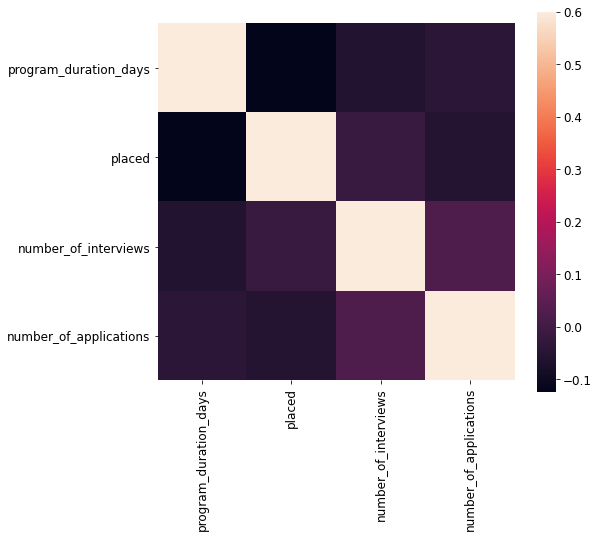

In [382]:
corrmat =pathrise_1.corr()
f, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(corrmat, vmax=0.6, square=True )

From the correlation matrix, we can see that correlation is low amongst the above variables

Let us get some insights:

Null Hypothesis H0: With the increase in program duration, the chances of placement are increased

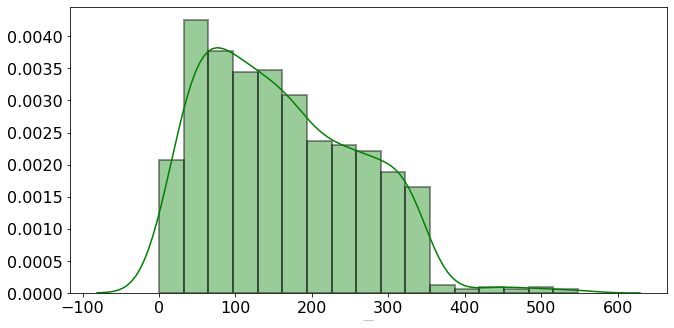

In [383]:
rcParams['figure.figsize'] = 10.7,5.27
c=sns.distplot(pathrise_placed["program_duration_days"], color="g",hist_kws=dict(edgecolor="k", linewidth=2))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [384]:
np.percentile(pathrise_placed.program_duration_days, [25, 50, 75])

array([ 76., 145., 237.])

25% of the fellows get placed by the 76th day and half of those fellows who got placed took less than 150 days (5 months)...
This suggests that students who lie outside q2 are facing more difficulty in being placed. Special effort needs to be made to ensure that they are getting proper training- resume review, workshop, interview training.

So my initial hypothesis was incorrect, the chances of placement do not increase linearly with the increase in the program duration

Hypothesis 2

Null hypothesis (H0) :Chance of being placed increses with the number of applications.

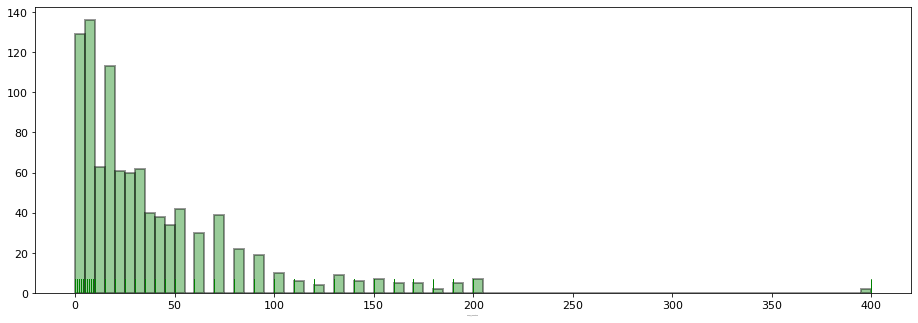

In [385]:
rcParams['figure.figsize'] = 15.7,5.27
sns.distplot(pathrise_placed["number_of_applications"],color="g",hist_kws=dict(edgecolor="k", linewidth=2), bins=80,kde=False, rug=True)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()


In [386]:
np.percentile(pathrise_placed.number_of_applications, [25, 50, 75])

#profile improvemnet needed if you have applied for more than50 jobs

array([ 8., 20., 45.])

Half of the fellows get placed within 20 applications, and 75 % of them need 45 applications, this is an exciting insight. 

It shows that the quality of the applicantion> quantity of applications.
Instead of randomly applying, it is better to select a few target companies and apply to them, reaching out to recruiters in these companies via cold emailing techniques, mail merging is a better strategy.

It also shows that people who have applied to more than 50 jobs and still have not been placed, Pathrise needs to improve their profile, via resume building adn other workshops.

The main focus for these fellows should not be just applying but enhancing their skills, profile etc.

H0: More the number of apllicantions, more sould be the number of interviews

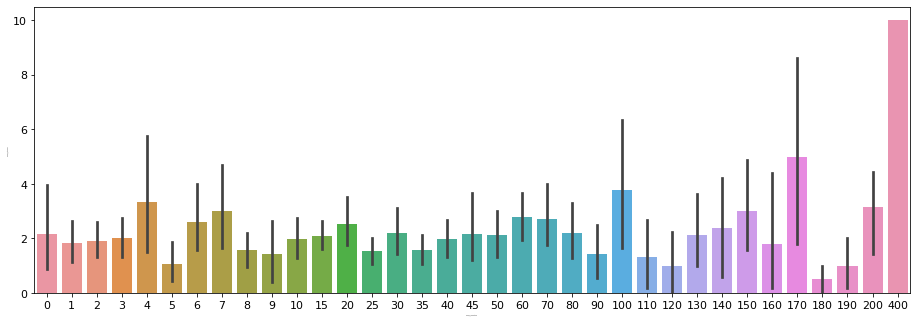

In [387]:
rcParams['figure.figsize'] = 15.7,5.27
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
sns.barplot(x="number_of_applications" ,y="number_of_interviews",data=pathrise_placed)

Although the graph does not provide great insights, we can infer that little less than 170 is the optimum number of applications fellow should make, more applications than that result in lower interview calls. 

(NOTE: I am disregarding the  value 400 for number of applications as it seems to be an outlier as discussed in the start)

This is because fellows are applying to random jobs instead of focusing on specific quality jobs. Cumulatively fellows who applied to less than 150 jobs secured more interviews.

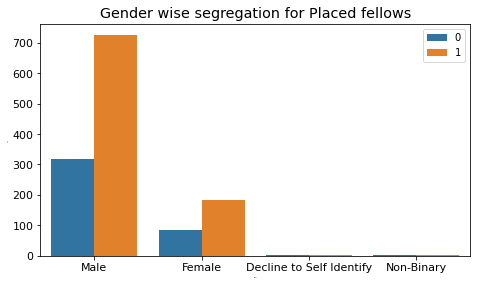

In [388]:
#lets see number of people placed/ failed based on gender
rcParams['figure.figsize'] = 7.7,4.27
sns.countplot("gender", hue="placed", data=pathrise_1)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(prop={"size":10})
plt.title('Gender wise segregation for Placed fellows')
plt.show()

In [389]:
print(" The Percentage of Males place were:", round((len(pathrise_1[(pathrise_1.gender == 'Male') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.gender == 'Male'])*100),2),"%")
print(" The Percentage of Feamles place were:", round((len(pathrise_1[(pathrise_1.gender == 'Female') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.gender == 'Female'])*100),2),"%")

 The Percentage of Males place were: 69.61 %
 The Percentage of Feamles place were: 68.54 %


The placement rate for males and females is very similar, so it appears there is no need to delve further into it. The number of samples for people who identified themselves as "Binay" is too few to generate insights.

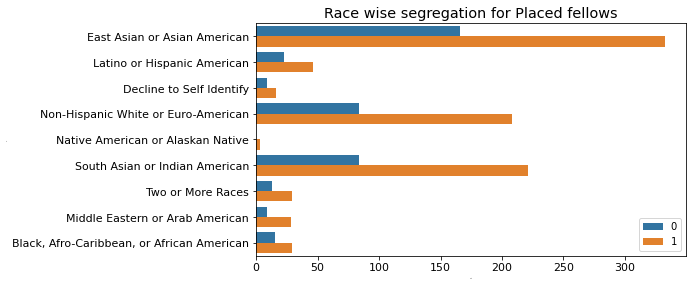

In [390]:
rcParams['figure.figsize'] = 7.7,4.27
sns.countplot(y="race", hue="placed", data=pathrise_1)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend( prop={"size":10})
plt.title('Race wise segregation for Placed fellows')
plt.show()

In [391]:
print(" The Percentage of fellows with race: East Asian or Asian American placed were:", round((len(pathrise_1[(pathrise_1.race == 'East Asian or Asian American') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.race == 'East Asian or Asian American'])*100),2),"%")
print(" The Percentage of fellows with race: Latino or Hispanic American placed were:", round((len(pathrise_1[(pathrise_1.race == 'Latino or Hispanic American') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.race == 'Latino or Hispanic American'])*100),2),"%")
print(" The Percentage of fellows with race: Non-Hispanic White or Euro-American placed were:", round((len(pathrise_1[(pathrise_1.race == 'Non-Hispanic White or Euro-American') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.race == 'Non-Hispanic White or Euro-American'])*100),2),"%")
print(" The Percentage of fellows with race: South Asian or Indian American:", round((len(pathrise_1[(pathrise_1.race == 'South Asian or Indian American') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.race == 'South Asian or Indian American'])*100),2),"%")
print(" The Percentage of fellows with race: Two or More Races placed were:", round((len(pathrise_1[(pathrise_1.race == 'Two or More Races') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.race == 'Two or More Races'])*100),2),"%")
print(" The Percentage of fellows with race: Middle Eastern or Arab American placed were:", round((len(pathrise_1[(pathrise_1.race == 'Middle Eastern or Arab American') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.race == 'Middle Eastern or Arab American'])*100),2),"%")
print(" The Percentage of fellows with race: Black, Afro-Caribbean, or African American:", round((len(pathrise_1[(pathrise_1.race == 'Black, Afro-Caribbean, or African American') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.race == 'Black, Afro-Caribbean, or African American'])*100),2),"%")

 The Percentage of fellows with race: East Asian or Asian American placed were: 66.73 %
 The Percentage of fellows with race: Latino or Hispanic American placed were: 66.67 %
 The Percentage of fellows with race: Non-Hispanic White or Euro-American placed were: 71.23 %
 The Percentage of fellows with race: South Asian or Indian American: 72.46 %
 The Percentage of fellows with race: Two or More Races placed were: 69.05 %
 The Percentage of fellows with race: Middle Eastern or Arab American placed were: 75.68 %
 The Percentage of fellows with race: Black, Afro-Caribbean, or African American: 65.91 %


Although most companies don't discriminate and are equal opportunity employers, it can be seen that fellows of the race Black, Afro-Caribbean, or African American have faced more difficulties in getting a job

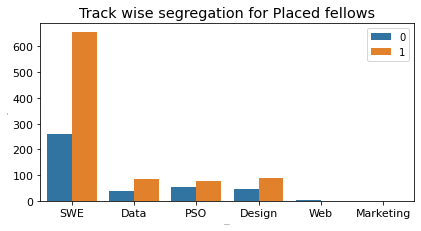

In [392]:
# as we can see, most of the fellows are enrolled in the swe track, lets see number of people placed/ failed based on gender
rcParams['figure.figsize'] = 6.7,3.27
sns.countplot("primary_track", hue="placed", data=pathrise_1)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(prop={"size":10})
plt.title('Track wise segregation for Placed fellows')
plt.show()


In [393]:
print(" The Percentage of SWE fellows placed were:", round((len(pathrise_1[(pathrise_1.primary_track == 'SWE') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.primary_track == 'SWE'])*100),2),"%")
print(" The Percentage of PSO fellows placed were:", round((len(pathrise_1[(pathrise_1.primary_track == 'PSO') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.primary_track == 'PSO'])*100),2),"%")
print(" The Percentage of Data fellows placed were:", round((len(pathrise_1[(pathrise_1.primary_track == 'Data') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.primary_track == 'Data'])*100),2),"%")
print(" The Percentage of Design fellows placed were:", round((len(pathrise_1[(pathrise_1.primary_track == 'Design') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.primary_track == 'Design'])*100),2),"%")

 The Percentage of SWE fellows placed were: 71.72 %
 The Percentage of PSO fellows placed were: 58.21 %
 The Percentage of Data fellows placed were: 69.35 %
 The Percentage of Design fellows placed were: 65.69 %


The fellow whose primary track is PSO had the lowest placement rate, while fellows with SWE had the highest placement rate. there is a need for improvement in the PSO track

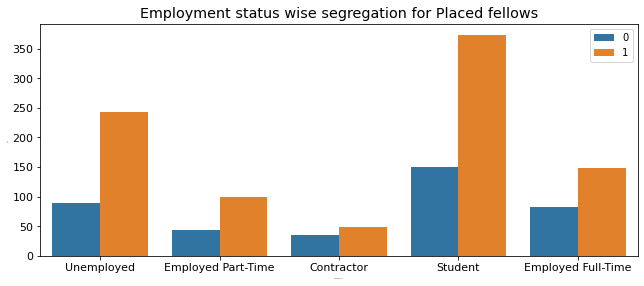

In [394]:
rcParams['figure.figsize'] = 10.7,4.27
c=sns.countplot("Employment_status", hue="placed", data=pathrise_1)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend( prop={"size":10})
plt.title('Employment status wise segregation for Placed fellows')
plt.show()

In [395]:
print(" The Percentage of Unemployed fellows placed were:", round((len(pathrise_1[(pathrise_1.Employment_status == 'Unemployed') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.Employment_status == 'Unemployed'])*100),2),"%")
print(" The Percentage of Employed Part-Time fellows placed were:", round((len(pathrise_1[(pathrise_1.Employment_status == 'Employed Part-Time') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.Employment_status == 'Employed Part-Time'])*100),2),"%")
print(" The Percentage of Student fellows placed were:", round((len(pathrise_1[(pathrise_1.Employment_status == 'Student') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.Employment_status == 'Student'])*100),2),"%")
print(" The Percentage of Employed full-time fellows placed were:", round((len(pathrise_1[(pathrise_1.Employment_status == 'Employed Full-Time') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.Employment_status == 'Employed Full-Time'])*100),2),"%")
print(" The Percentage of Contractor fellows placed were:", round((len(pathrise_1[(pathrise_1.Employment_status == 'Contractor') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.Employment_status == 'Contractor'])*100),2),"%")

 The Percentage of Unemployed fellows placed were: 72.97 %
 The Percentage of Employed Part-Time fellows placed were: 69.44 %
 The Percentage of Student fellows placed were: 71.32 %
 The Percentage of Employed full-time fellows placed were: 64.07 %
 The Percentage of Contractor fellows placed were: 57.65 %


Contractors have the lowest placement rate, while unemployed fellows had the highest!
It could be because unemployed fellows are more desperate to find a job. Hence they will put additional efforts, and they might accept the first job offer they receive to avoid continuous unemployment.

While contractors are typically more experienced people who get paid on an hourly basis (i.e., a higher salary), so they might not be satisfied with a lower job offer and continue to strive for a much better job instead of lowering their expectations

Further analysis needs to be done for contractors based on their number of years of experience and job search length, which will help get better insights.

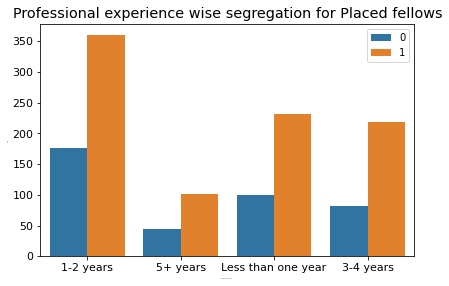

In [396]:
rcParams['figure.figsize'] = 6.7,4.27
plt.title('Professional experience wise segregation for Placed fellows')
sns.countplot("professional_experience", hue="placed", data=pathrise_1)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend( prop={"size":10})

plt.show()

In [397]:
print("The Percentage of fellows with 1-2 years of experience placed were:", round((len(pathrise_1[(pathrise_1.professional_experience == '1-2 years') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.professional_experience == '1-2 years'])*100),2),"%")
print("The Percentage of fellows with 5+ years of experience placed were:", round((len(pathrise_1[(pathrise_1.professional_experience == '5+ years') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.professional_experience == '5+ years'])*100),2),"%")
print("The Percentage of fellows with Less than one year of experience placed were:", round((len(pathrise_1[(pathrise_1.professional_experience == 'Less than one year') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.professional_experience == 'Less than one year'])*100),2),"%")
print("The Percentage of fellows with 3-4 years of experience placed were:", round((len(pathrise_1[(pathrise_1.professional_experience == '3-4 years') & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.professional_experience == '3-4 years'])*100),2),"%")

The Percentage of fellows with 1-2 years of experience placed were: 67.04 %
The Percentage of fellows with 5+ years of experience placed were: 69.39 %
The Percentage of fellows with Less than one year of experience placed were: 70.09 %
The Percentage of fellows with 3-4 years of experience placed were: 72.76 %


Although the placement rate is similar across fellows with various years of experience, fellows with 1-2 years of experience had a lower chance of getting placed.

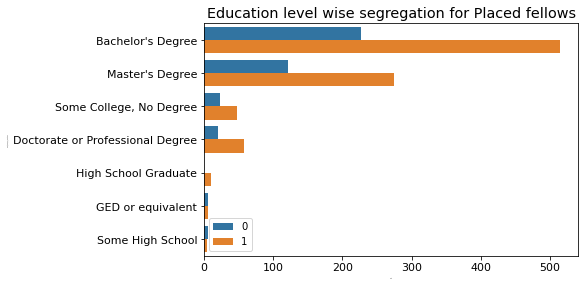

In [398]:
plt.title('Education level wise segregation for Placed fellows')
rcParams['figure.figsize'] = 9.7,3.27
sns.countplot(y="highest_level_of_education", hue="placed", data=pathrise_1)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend( prop={"size":10})

plt.show()

In [399]:
print("The Percentage of fellows with Bachelor's Degree placed were:", round((len(pathrise_1[(pathrise_1.highest_level_of_education == "Bachelor's Degree") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.highest_level_of_education == "Bachelor's Degree"])*100),2),"%")
print("The Percentage of fellows with Master's Degree placed were:", round((len(pathrise_1[(pathrise_1.highest_level_of_education == "Master's Degree") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.highest_level_of_education == "Master's Degree"])*100),2),"%")
print("The Percentage of fellows with Doctorate or Professional Degree placed were:", round((len(pathrise_1[(pathrise_1.highest_level_of_education == "Doctorate or Professional Degree") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.highest_level_of_education == "Doctorate or Professional Degree"])*100),2),"%")
print("The Percentage of fellows from Some College, or having No Degree placed were:", round((len(pathrise_1[(pathrise_1.highest_level_of_education == "Some College, No Degree") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.highest_level_of_education == "Some College, No Degree"])*100),2),"%")

#Since the number of fellows with other educational degrees are less, we group them togjeter to see the success percent of placing them
x=len(pathrise_1[(pathrise_1.highest_level_of_education == "High School Graduate")])
y=len(pathrise_1[(pathrise_1.highest_level_of_education == "GED or equivalent")])
z=len(pathrise_1[(pathrise_1.highest_level_of_education == "Some High School")])
a=len(pathrise_1[(pathrise_1.highest_level_of_education == "High School Graduate")&(pathrise_1.placed ==1)])
b=len(pathrise_1[(pathrise_1.highest_level_of_education == "GED or equivalent")&(pathrise_1.placed ==1)])
c=len(pathrise_1[(pathrise_1.highest_level_of_education == "HSome High School")&(pathrise_1.placed ==1)])

print("The Percentage of fellows with other Degrees placed were:", round((a+b+c)/(x+y+z)*100,2),"%")

The Percentage of fellows with Bachelor's Degree placed were: 69.41 %
The Percentage of fellows with Master's Degree placed were: 69.27 %
The Percentage of fellows with Doctorate or Professional Degree placed were: 74.03 %
The Percentage of fellows from Some College, or having No Degree placed were: 67.14 %
The Percentage of fellows with other Degrees placed were: 50.0 %


Fellows who had just some college degree or had no degree found the most considerable difficulty in being placed.

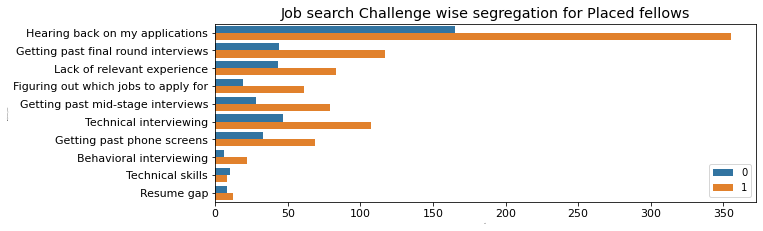

In [400]:
plt.title('Job search Challenge wise segregation for Placed fellows')
rcParams['figure.figsize'] = 9.7,3.27
sns.countplot(y="biggest_challenge_in_search", hue="placed", orient="h",data=pathrise_1)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(prop={"size":10})
plt.show()

In [401]:
print("The Percentage of fellows who's biggest challenge was Hearing back on their applications got placed were:", round((len(pathrise_1[(pathrise_1.biggest_challenge_in_search == "Hearing back on my applications") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.biggest_challenge_in_search == "Hearing back on my applications"])*100),2),"%")
print("The Percentage of fellows who's biggest challenge was Getting past final round interviews got placed were:", round((len(pathrise_1[(pathrise_1.biggest_challenge_in_search == "Getting past final round interviews") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.biggest_challenge_in_search == "Getting past final round interviews"])*100),2),"%")
print("The Percentage of fellows who's biggest challenge was Lack of relevant experience got placed were:", round((len(pathrise_1[(pathrise_1.biggest_challenge_in_search == "Lack of relevant experience") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.biggest_challenge_in_search == "Lack of relevant experience"])*100),2),"%")
print("The Percentage of fellows who's biggest challenge was Figuring out which jobs to apply for got placed were:", round((len(pathrise_1[(pathrise_1.biggest_challenge_in_search == "Figuring out which jobs to apply for") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.biggest_challenge_in_search == "Figuring out which jobs to apply for"])*100),2),"%")
print("The Percentage of fellows who's biggest challenge was Getting past mid-stage interviews got placed were:", round((len(pathrise_1[(pathrise_1.biggest_challenge_in_search == "Getting past mid-stage interviews") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.biggest_challenge_in_search == "Getting past mid-stage interviews"])*100),2),"%")
print("The Percentage of fellows who's biggest challenge was Technical interviewing got placed were:", round((len(pathrise_1[(pathrise_1.biggest_challenge_in_search == "Technical interviewing") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.biggest_challenge_in_search == "Technical interviewing"])*100),2),"%")
print("The Percentage of fellows who's biggest challenge was Getting past phone screens got placed were:", round((len(pathrise_1[(pathrise_1.biggest_challenge_in_search == "Getting past phone screens") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.biggest_challenge_in_search == "Getting past phone screens"])*100),2),"%")
print("The Percentage of fellows who's biggest challenge was Behavioral interviewing got placed were:", round((len(pathrise_1[(pathrise_1.biggest_challenge_in_search == "Behavioral interviewing") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.biggest_challenge_in_search == "Behavioral interviewing"])*100),2),"%")
print("The Percentage of fellows who's biggest challenge was Technical skills got placed were:", round((len(pathrise_1[(pathrise_1.biggest_challenge_in_search == "Technical skills") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.biggest_challenge_in_search == "Technical skills"])*100),2),"%")
print("The Percentage of fellows who's biggest challenge was Resume gap got placed were:", round((len(pathrise_1[(pathrise_1.biggest_challenge_in_search == "Resume gap") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.biggest_challenge_in_search == "Resume gap"])*100),2),"%")

The Percentage of fellows who's biggest challenge was Hearing back on their applications got placed were: 68.27 %
The Percentage of fellows who's biggest challenge was Getting past final round interviews got placed were: 72.67 %
The Percentage of fellows who's biggest challenge was Lack of relevant experience got placed were: 65.87 %
The Percentage of fellows who's biggest challenge was Figuring out which jobs to apply for got placed were: 76.25 %
The Percentage of fellows who's biggest challenge was Getting past mid-stage interviews got placed were: 73.83 %
The Percentage of fellows who's biggest challenge was Technical interviewing got placed were: 69.48 %
The Percentage of fellows who's biggest challenge was Getting past phone screens got placed were: 67.65 %
The Percentage of fellows who's biggest challenge was Behavioral interviewing got placed were: 78.57 %
The Percentage of fellows who's biggest challenge was Technical skills got placed were: 44.44 %
The Percentage of fellows wh

fellows whose most significant challenge was lack of technical skills faced great difficulties in being placed.

By further analyzing what their primary track was, we could understand it better and suggest them to either change their track or focus exclusively on workshops to improve tech skills

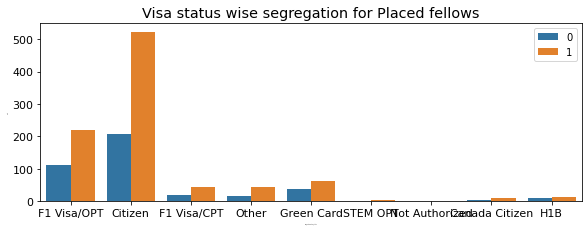

In [402]:
plt.title('Visa status wise segregation for Placed fellows')
rcParams['figure.figsize'] = 19.7,3.27
sns.countplot("work_authorization_status", hue="placed", data=pathrise_1)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend( prop={"size":10})

plt.show()

In [403]:
print("The Percentage of fellows with F1 Visa/OPT placed were:", round((len(pathrise_1[(pathrise_1.work_authorization_status == "F1 Visa/OPT") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.work_authorization_status == "F1 Visa/OPT"])*100),2),"%")
print("The Percentage of fellows with American Citizenship placed were:", round((len(pathrise_1[(pathrise_1.work_authorization_status == "Citizen") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.work_authorization_status == "Citizen"])*100),2),"%")
print("The Percentage of fellows with F1 Visa/CPT placed were:", round((len(pathrise_1[(pathrise_1.work_authorization_status == "F1 Visa/CPT") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.work_authorization_status == "F1 Visa/CPT"])*100),2),"%")
print("The Percentage of fellows with Other visas placed were:", round((len(pathrise_1[(pathrise_1.work_authorization_status == "Green Card") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.work_authorization_status == "Green Card"])*100),2),"%")
print("The Percentage of fellows with Green Card placed were:", round((len(pathrise_1[(pathrise_1.work_authorization_status == "Other") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.work_authorization_status == "Other"])*100),2),"%")
print("The Percentage of fellows with Canadian Citizenship placed were:", round((len(pathrise_1[(pathrise_1.work_authorization_status == "Canada Citizen") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.work_authorization_status == "Canada Citizen"])*100),2),"%")
print("The Percentage of fellows with H1B visas placed were:", round((len(pathrise_1[(pathrise_1.work_authorization_status == "H1B") & (pathrise_1.placed ==1)])/len(pathrise_1[pathrise_1.work_authorization_status == "H1B"])*100),2),"%")

The Percentage of fellows with F1 Visa/OPT placed were: 66.36 %
The Percentage of fellows with American Citizenship placed were: 71.74 %
The Percentage of fellows with F1 Visa/CPT placed were: 67.74 %
The Percentage of fellows with Other visas placed were: 63.64 %
The Percentage of fellows with Green Card placed were: 75.44 %
The Percentage of fellows with Canadian Citizenship placed were: 69.23 %
The Percentage of fellows with H1B visas placed were: 54.55 %


Fellows, who had an H1B visa, faced great hardships in getting placed. This could be because of the government's recent changes, which made the regulations around it stricter.

H1B visa holders need to extend their visas every few years, and the new rules have made it difficult. 

Many H1b visa holders also change jobs, and a new company might be reluctant to do the administrative and legal paperwork for it as it is a big hassle.

# PART 1B: Building a Machine Learning Model to predict if a student gets placed

In [404]:
# since we alrady have the pathrise placed column, we drop the status column as it is redundant 
pathrise_1=pathrise_1.drop("pathrise_status",1)
pathrise_1.head()

,primary_track,program_duration_days,placed,Employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race
4,SWE,89.0,1,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American
7,SWE,19.0,0,Employed Part-Time,Bachelor's Degree,Less than one month,Getting past final round interviews,1-2 years,Citizen,4.0,15,Female,Latino or Hispanic American
11,Data,158.0,0,Unemployed,Master's Degree,3-5 months,Lack of relevant experience,5+ years,Citizen,5.0,50,Male,Decline to Self Identify
13,PSO,52.0,0,Employed Part-Time,Bachelor's Degree,1-2 months,Lack of relevant experience,Less than one year,Citizen,4.0,40,Male,Non-Hispanic White or Euro-American
22,SWE,93.0,0,Contractor,Bachelor's Degree,6 months to a year,Hearing back on my applications,1-2 years,Citizen,1.0,10,Female,East Asian or Asian American


Most of the attributes in the dataset are categorical. For a machine-learning algorithm to accept it, I need to convert them into integers.

If the columns had contained binary values (i.e., only two unique values in a column example: Gender: Male and Female), I would have encoded them, i.e., male 0, female 1. 

But since there are multiple values in every column ( example: Gender: Male, Female, Non-binary, etc.) I cannot directly convert them to binary values, and encoding them into integers like 1,2,3, etc. will not make sense when put in the prediction algorithm),

I encoded the categorical variables into separate columns to increase teh efficiency of the machine learning algorithms I am about to sue ( one-hot encoding)

In [405]:
category=["primary_track","Employment_status","highest_level_of_education","length_of_job_search","biggest_challenge_in_search","professional_experience","work_authorization_status","gender","race"]
pathrise_1=pd.get_dummies(data=pathrise_1, columns= category)

Now that our data is in the form that machine learning algorithms can understand, I will spit it into test and train to build our model around it.

In [406]:
X_train, X_test, y_train, y_test = train_test_split(pathrise_1.drop('placed', 1), pathrise_1['placed'], test_size = .2, random_state=10, shuffle= True) #split the dat

I checked the importance of all the columns with respect to the target variable

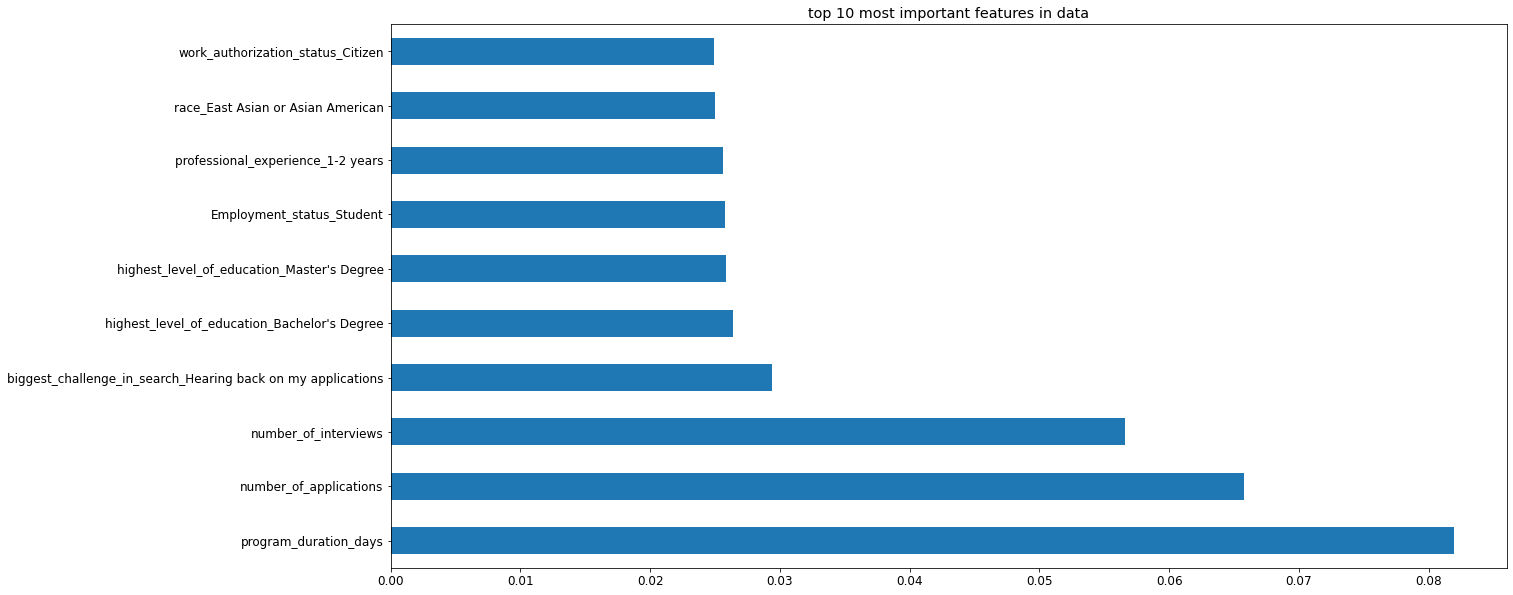

In [407]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
#print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh',figsize=(20,10))
plt.title("top 10 most important features in data")
plt.show()

In [408]:
feat_importances.nlargest(10)

program_duration_days                                          0.081913
number_of_applications                                         0.065764
number_of_interviews                                           0.056557
biggest_challenge_in_search_Hearing back on my applications    0.029351
highest_level_of_education_Bachelor's Degree                   0.026376
highest_level_of_education_Master's Degree                     0.025804
Employment_status_Student                                      0.025777
professional_experience_1-2 years                              0.025587
race_East Asian or Asian American                              0.025018
work_authorization_status_Citizen                              0.024878
dtype: float64

# Model 1: Decision tree

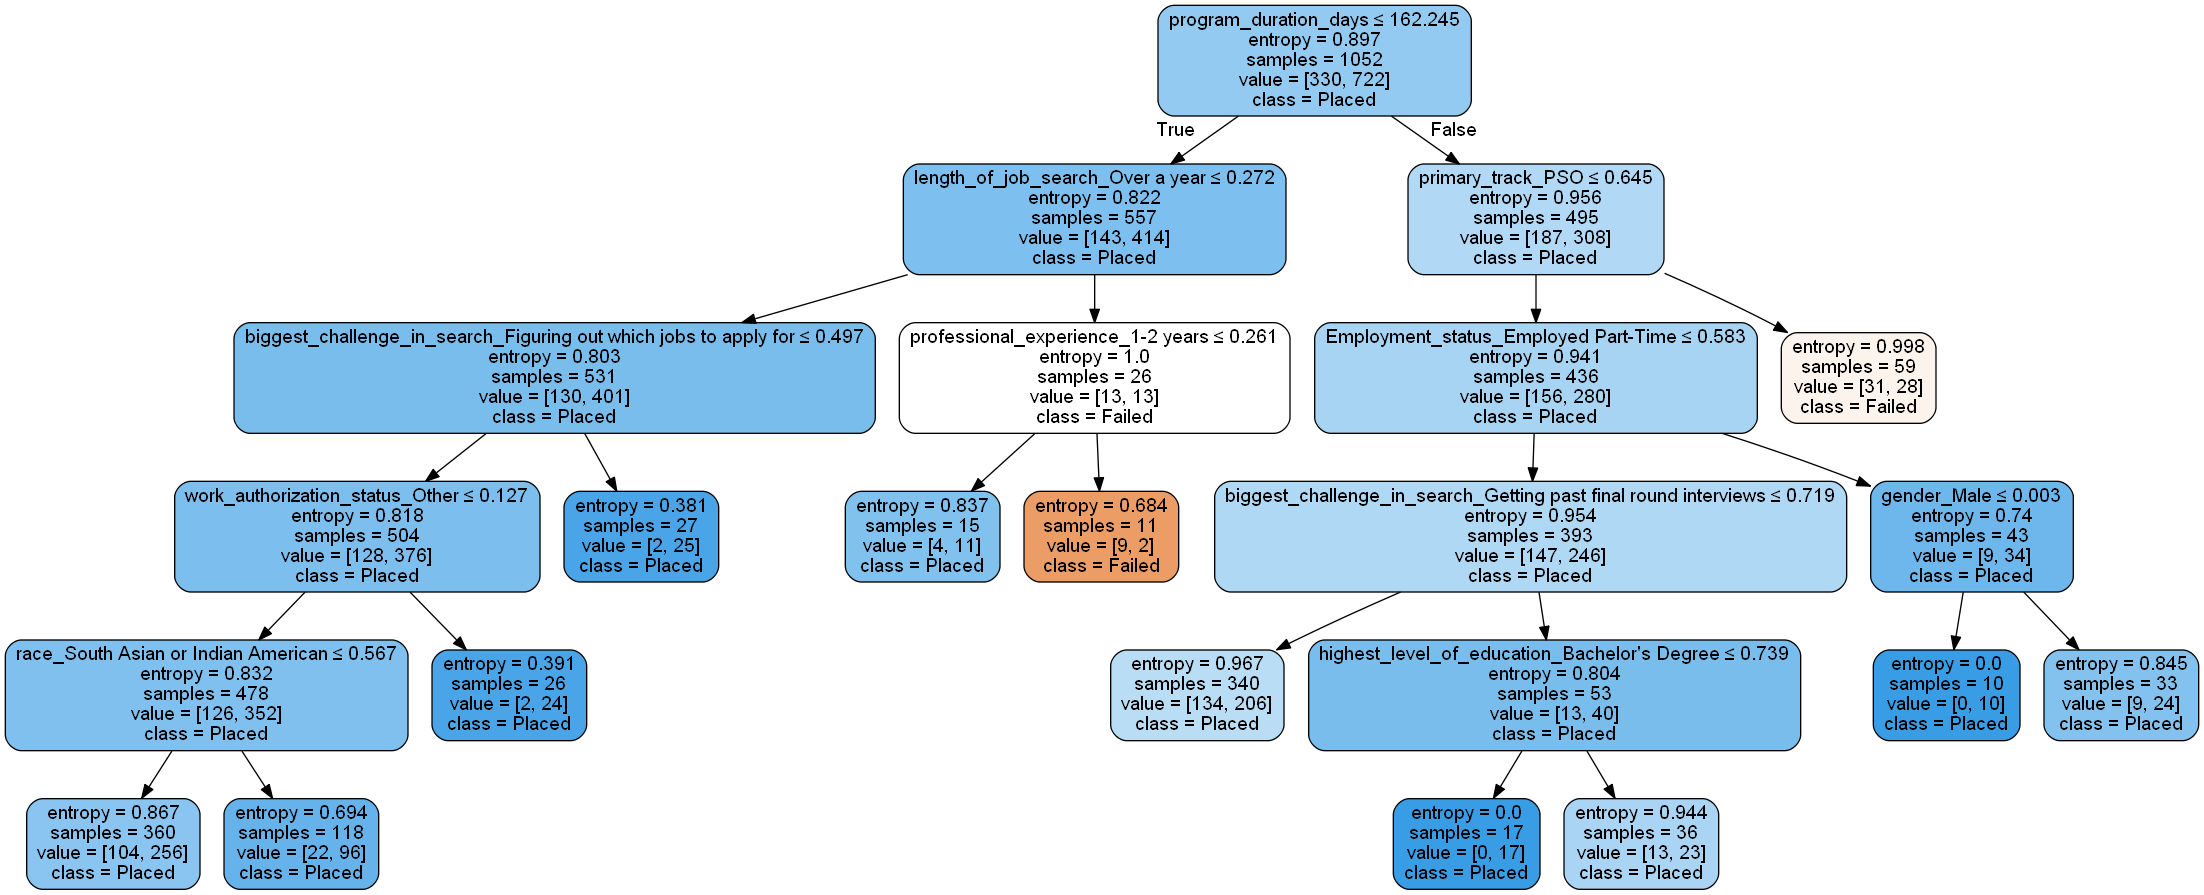

In [409]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38/bin/'
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus


from sklearn import tree

feature_cols=X_train.columns
dtree = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'random', max_leaf_nodes = 12, min_samples_leaf = 9, max_depth= 5)
dtree=dtree.fit(X_train,y_train)
y_predp = dtree.predict(X_test)

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Failed','Placed'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

now we calculate the sucess of the model

In [410]:
confusion_matrix = confusion_matrix(y_test, y_predp)
confusion_matrix

array([[  2,  71],
       [  8, 183]], dtype=int64)

In [411]:
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

accuracy=(confusion_matrix[1,1]+confusion_matrix[0,0])/total
print('Accuracy: ', accuracy)

Sensitivity :  0.2
Specificity :  0.7204724409448819
Accuracy:  0.7007575757575758


We also look at AUC, ROC to check accuracy

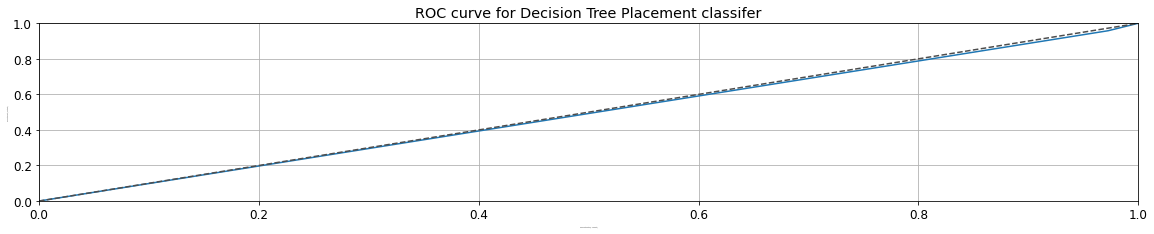

In [412]:
fpr, tpr, thresholds = roc_curve(y_test, y_predp)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Decision Tree Placement classifer')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [413]:
auc1=auc(fpr, tpr)
auc1

0.49275622176002287

# Model 2 : Random Forest

In [414]:
model = RandomForestClassifier(random_state=1,bootstrap=False, max_depth=5 , max_features='auto', min_samples_leaf= 4, min_samples_split =5)
model=model.fit(X_train, y_train)
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

In [415]:
from sklearn.metrics import confusion_matrix
confusion_matrix2 = confusion_matrix(y_test, y_pred_bin)
confusion_matrix2
#max_depth=25,n_estimators=40,criterion="entropy", 

array([[  3,  70],
       [  0, 191]], dtype=int64)

In [416]:
total2=sum(sum(confusion_matrix2))

sensitivity_2 = confusion_matrix2[0,0]/(confusion_matrix2[0,0]+confusion_matrix2[1,0])
print('Sensitivity : ', sensitivity_2)

specificity_2 = confusion_matrix2[1,1]/(confusion_matrix2[1,1]+confusion_matrix2[0,1])
print('Specificity : ', specificity_2)

accuracy_2=(confusion_matrix2[1,1]+confusion_matrix2[0,0])/total2
print('Accuracy: ', accuracy_2)

Sensitivity :  1.0
Specificity :  0.7318007662835249
Accuracy:  0.7348484848484849


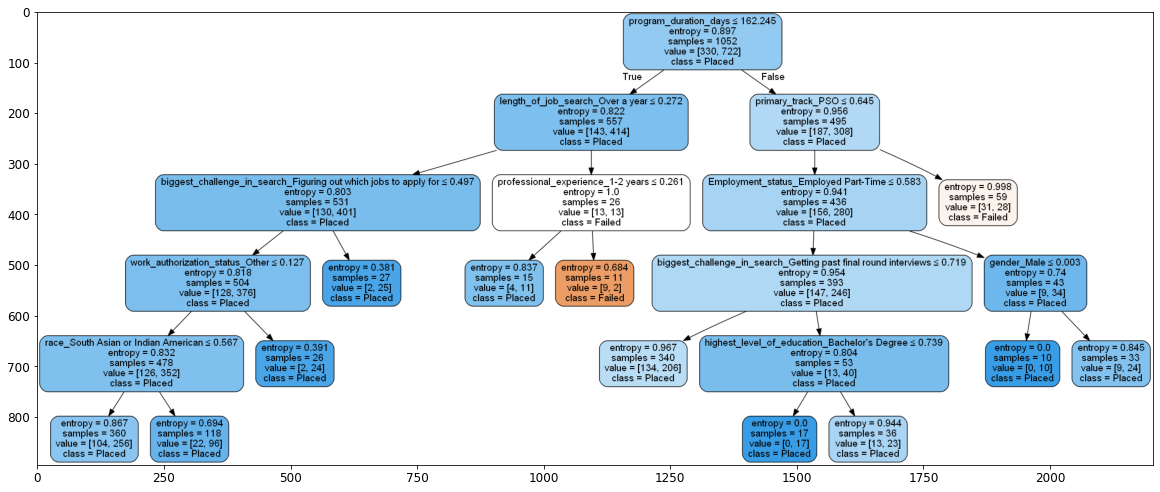

In [417]:
import matplotlib.image as mpimg
import io


estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_cols,
                class_names = ['Failed','Placed'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

pydotplus.graph_from_dot_data(dot_data.getvalue()).write_png('tree.png')

plt.figure(figsize=(20,20))
img = mpimg.imread('tree.png')
imgplot = plt.imshow(img)

plt.show()


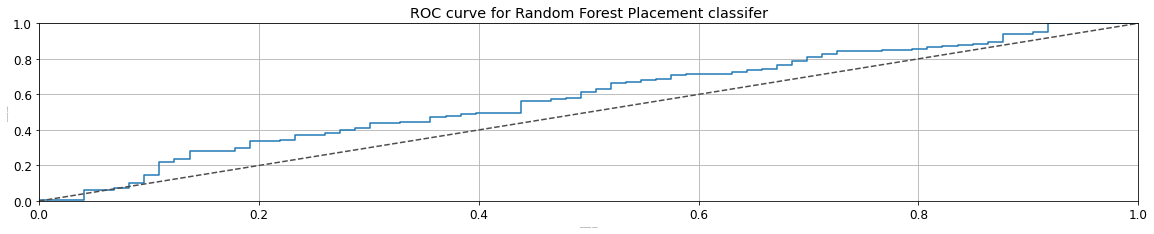

In [418]:
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_quant)

fig2, ax2 = plt.subplots()
ax2.plot(fpr2, tpr2)
ax2.plot([0, 1], [0, 1], transform=ax2.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Random Forest Placement classifer')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [419]:
auc2=auc(fpr2, tpr2)
auc2

0.5824428028401348

# Model 3: Logistic Regression

In [420]:
logreg = LogisticRegression()
logreg=logreg.fit(X_train, y_train)
y_predict_log = logreg.predict(X_test)
y_pred__log_quant = logreg.predict_proba(X_test)[:, 1]
y_pred_log_bin = logreg.predict(X_test)

C:\Users\imsid\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [421]:
confusion_matrix3= confusion_matrix(y_test, y_pred_log_bin)
confusion_matrix3

array([[  6,  67],
       [  7, 184]], dtype=int64)

In [422]:
total3=sum(sum(confusion_matrix3))

sensitivity_3 = confusion_matrix3[0,0]/(confusion_matrix3[0,0]+confusion_matrix3[1,0])
print('Sensitivity : ', sensitivity_3 )

specificity_3 = confusion_matrix3[1,1]/(confusion_matrix3[1,1]+confusion_matrix3[0,1])
print('Specificity : ', specificity_3)

accuracy_3=(confusion_matrix3[1,1]+confusion_matrix3[0,0])/total3
print('Accuracy: ', accuracy_3)

Sensitivity :  0.46153846153846156
Specificity :  0.7330677290836654
Accuracy:  0.7196969696969697


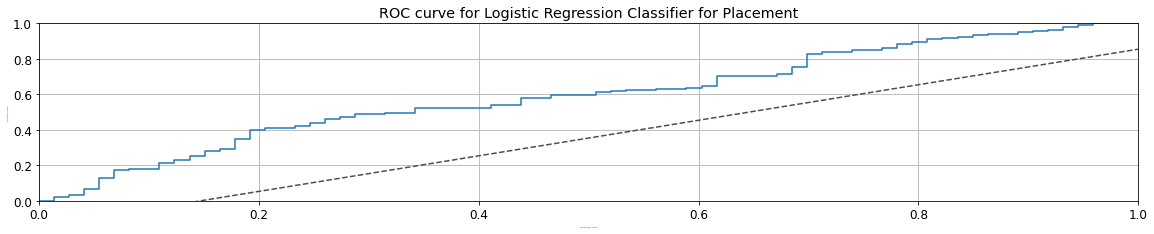

In [424]:
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred__log_quant)

fig, ax3 = plt.subplots()
ax3.plot(fpr3, tpr3)
ax3.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Logistic Regression Classifier for Placement')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [425]:
auc3=auc(fpr3, tpr3)
auc3

0.5968586387434555

In [427]:
People_List = [[sensitivity,specificity,accuracy, auc1],[sensitivity_2,specificity_2,accuracy_2, auc2],[sensitivity_3,specificity_3,accuracy_3, auc3]]
Algo=["Decision Tree","RandomForest","Logistic Regression"]
df = DataFrame (People_List,columns=['Sensitivity','Specificity','Accuracy',"Area under the curve"])

df=df.assign(Algorithm=Algo)

print (df)

   Sensitivity  Specificity  Accuracy  Area under the curve  \
0     0.200000     0.720472  0.700758              0.492756   
1     1.000000     0.731801  0.734848              0.582443   
2     0.461538     0.733068  0.719697              0.596859   

             Algorithm  
0        Decision Tree  
1         RandomForest  
2  Logistic Regression  


From the three models, Randomforest Classiifeer had the highest accuracy, so I have selected it, and I will make predictions on the unseen data (active fellows) using it, but the accuracy is still poor, since the dataset is small, to avoid skewness, I have decided to oversample the data using SMOTE

# SMOTE : Over Sampling

In [428]:
X_train_os , y_train_os = SMOTE(random_state=0).fit_sample(X_train, y_train)
X_test_os, y_test_os = SMOTE(random_state=0).fit_sample(X_test, y_test)

X_train2 = pd.DataFrame(X_train_os ,columns=X_train.columns)
X_test2 = pd.DataFrame(X_test_os ,columns=X_test.columns)

C:\Users\imsid\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\imsid\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Since Random forest Classifer was the algorithm with best accuracy, we rebuild it after transforming the training and testing datest using SMOTE

In [429]:
model = RandomForestClassifier(random_state=1,bootstrap=False, max_depth=90 , max_features='auto', min_samples_leaf= 3, min_samples_split =15)
model=model.fit(X_train2, y_train_os)
y_predict = model.predict(X_test2)
y_pred_quant = model.predict_proba(X_test2)[:, 1]
y_pred_bin = model.predict(X_test2)


confusion_matrix4 = confusion_matrix(y_test_os, y_pred_bin)
confusion_matrix4


total4=sum(sum(confusion_matrix4))

sensitivity_4 = confusion_matrix4[0,0]/(confusion_matrix4[0,0]+confusion_matrix4[1,0])
print('Sensitivity : ', sensitivity_4)

specificity_4 = confusion_matrix4[1,1]/(confusion_matrix4[1,1]+confusion_matrix4[0,1])
print('Specificity : ', specificity_4)

accuracy_4=(confusion_matrix4[1,1]+confusion_matrix4[0,0])/total4
print('Accuracy: ', accuracy_4)


Sensitivity :  0.937984496124031
Specificity :  0.7233201581027668
Accuracy:  0.7958115183246073


In [430]:
print("Accuracy of the RandomForestClassifier before over sampling was : ", accuracy_2)
print("Accuracy of the RandomForestClassifier after over sampling is : ", accuracy_4)

Accuracy of the RandomForestClassifier before over sampling was :  0.7348484848484849
Accuracy of the RandomForestClassifier after over sampling is :  0.7958115183246073


After oversampling, I am sure Random forest is the best algorithm, and it has achieved an accuracy of almost 80%, I will use it to test the unseen data ie, active fellows who have not been placed yet.

Based on their information like work status, the primary track, etc., I will use the Random forest classifier to predict whether they will get placed.

# PART 1C: Testing the model on unseen Data ( active Pathrise fellows)

In [ ]:
I had already subsetted the data frame to extract data for the current fellows in- pathrise_active, and now I will clean it to drop unnecessary columns.

In [431]:
pathrise_active.isna().sum()

pathrise_status                  0
primary_track                    0
program_duration_days          532
placed                           0
Employment_status                0
highest_level_of_education       0
length_of_job_search             0
biggest_challenge_in_search      0
professional_experience          0
work_authorization_status        0
number_of_interviews            37
number_of_applications           0
gender                           0
race                             0
dtype: int64

In [432]:
pathrise_active.shape

(532, 14)

From the above two-cell, it can be inferred that pathrise_active contains all null values for program_duration_days, so we drop it as there is nothing from which we can understand the missing data.
number_of_interviews contains only a few missing values, so we impute it

In [433]:
#subsetting to focus on only current fellows, also the column program_duration/_dyas contains all null values, no point of subsetting

pathrise_active=pathrise_active.drop(['program_duration_days','placed',"pathrise_status"] ,axis=1)
pathrise_active.number_of_interviews=imputer.fit_transform(pathrise_active.number_of_interviews)

just like in part 1B, we use one-hot encoding to convert the categorical variables into dummy variables

In [434]:
category2=["primary_track","Employment_status","highest_level_of_education","length_of_job_search","biggest_challenge_in_search","professional_experience","work_authorization_status","gender","race"]
pathrise_active=pd.get_dummies(data=pathrise_active, columns= category2)

In [435]:
X_train.shape

(1052, 62)

In [436]:
pathrise_active.shape

(532, 58)

I have run into a problem; the columns in the unseen test data are just 58 compared to 62  in the trained data based on which the Random Forest Classifier model was developed.

This happened because I had one hot encoded the columns, so every unique variable in the columns (of trained data) turned into a new column. However, in the unseen test data of active fellows (pathrise_active), those columns did not contain the same number of unique variables as the trained data.

So I will drop the columns that are not shared between the test and train data and rebuild the model, first test it on the seen data, and then on the unseen data.

In [437]:
common_cols = [col for col in set(X_train.columns).intersection(pathrise_active.columns)]
X_train_common=X_train[common_cols]
X_test_common=X_test[common_cols]

Based on these new columns, I will rebuild the random forest model to classify whether the students got placed or not. First I will oversample the data, then I will train it and test it on seen data later finally on unseen data (pathrise_active).

Just like we did it in PART 1B

As shown in PART 1, using the SMOTE technique, the accuracy of the model can be improved. This is because data is unbalanced ( more fellows who got placed vs. who withdrew) so I'll apply it to the train and test data

In [438]:
X_train_os , y_train_os = SMOTE(random_state=0).fit_sample(X_train_common, y_train)
X_test_os, y_test_os = SMOTE(random_state=0).fit_sample(X_test_common, y_test)

X_train_active_os = pd.DataFrame(X_train_os ,columns=X_train_common.columns)
X_test_active_os = pd.DataFrame(X_test_os ,columns=X_test_common.columns)

C:\Users\imsid\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\imsid\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [439]:
model0 = RandomForestClassifier(random_state=1,bootstrap=False, max_depth=90 , max_features='auto', min_samples_leaf= 3, min_samples_split =15)
model0=model0.fit(X_train_active_os, y_train_os)
y_predict0 = model0.predict(X_test_active_os)
y_pred_quant0 = model0.predict_proba(X_test_active_os)[:, 1]
y_pred_bin0 = model0.predict(X_test_active_os)


confusion_matrix5 = confusion_matrix(y_test_os, y_pred_bin0)
confusion_matrix5
#max_depth=25,n_estimators=40,criterion="entropy", 

total5=sum(sum(confusion_matrix5))

sensitivity_5 = confusion_matrix5[0,0]/(confusion_matrix5[0,0]+confusion_matrix5[1,0])
print('Sensitivity : ', sensitivity_5)

specificity_5 = confusion_matrix5[1,1]/(confusion_matrix5[1,1]+confusion_matrix5[0,1])
print('Specificity : ', specificity_5)

accuracy_5=(confusion_matrix5[1,1]+confusion_matrix4[0,0])/total5
print('Accuracy: ', accuracy_5)


Sensitivity :  0.9307692307692308
Specificity :  0.7222222222222222
Accuracy:  0.7931937172774869


Finally, the model has been rebuilt, trained, and tested on the seen data ( achieving an acurracy of almost 80%) , now I will test it on fellows who are currently active and predict how much time they will take

In [440]:
y_predict_active = model0.predict(pathrise_active)
y_predict_active

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

If someone wants to know whether a fellow will get placed, they can enter his values corresponding to the columns in the model like gender_male, gender female and store it in a list eg: l=[1,0,.....]

Then predict it using the model as below

x=model.predict(l)
x

Now I drew a tree based on the model above to predict whether an active student will get placed.

for any node which says some sttrbriuter< XYZ, if the values is less than 0.5 treat it as 0  and if it is greater than 0.5 treat it as 1 

primary_tarck_Data < 0.3 it means primary_track_Data=0 ie the fellow is currently not enrolled in the Data track

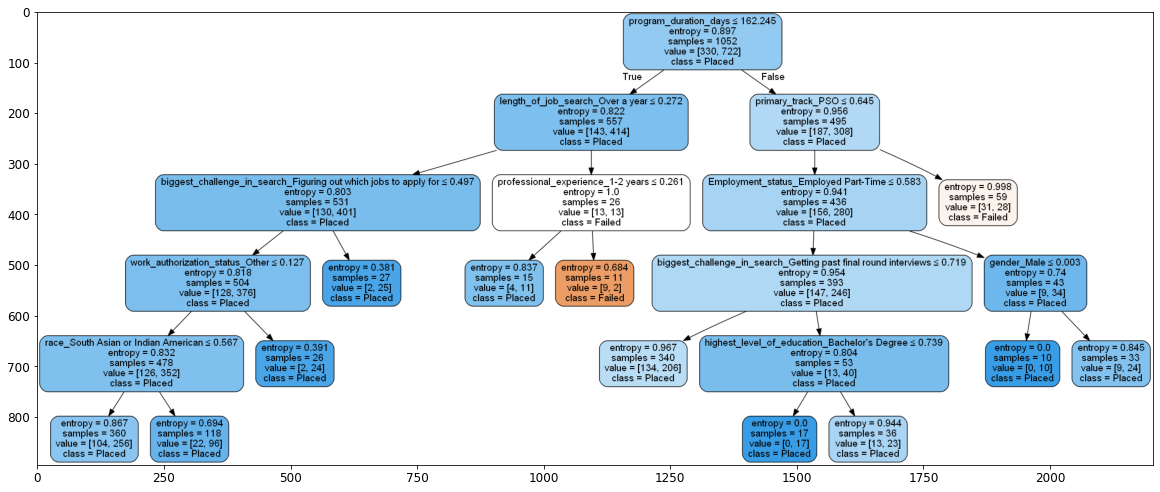

In [441]:
estimator = model0.estimators_[5]
feature_cols= pathrise_active.columns

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_cols,
                class_names = ['Failed','Placed'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

pydotplus.graph_from_dot_data(dot_data.getvalue()).write_png('tree.png')

plt.figure(figsize=(20,20))
img = mpimg.imread('tree.png')
imgplot = plt.imshow(img)


plt.show()


In [370]:
# _________________________________________________________________________________________________________________________-

In [ ]:
#END OF PART 1

# Part 2 :Predicting how much time a fellow will take to get placed

We subset the original data frame to focus on only those who got placed, and remove the outliers as mentioned in PART 1

In [442]:
pathrise_placed = pathrise[pathrise["placed"] ==1]
pathrise_placed = pathrise_placed[(pathrise_placed["program_duration_days"] > 0) & (pathrise_placed["program_duration_days"]<366)]

Now I check if there are any missing values

In [443]:
pathrise_placed.isna().sum()

pathrise_status                 0
primary_track                   0
program_duration_days           0
placed                          0
Employment_status               0
highest_level_of_education      0
length_of_job_search            0
biggest_challenge_in_search     0
professional_experience         0
work_authorization_status       0
number_of_interviews           78
number_of_applications          0
gender                          0
race                            0
dtype: int64

Now I impute the missing values and drop the unnecessary columns

In [444]:
pathrise_placed.number_of_interviews=imputer.fit_transform(pathrise_placed.number_of_interviews)
pathrise_placed=pathrise_placed.drop(['placed','pathrise_status'] ,axis=1)

# Part 2 A: EDA- Let us get some insights into how much does it take to get placed

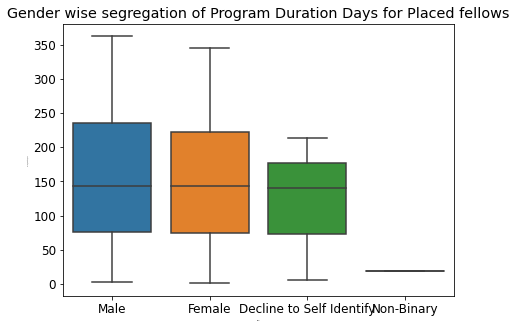

In [445]:
plt.figure(figsize =(7,5))
sns.boxplot(y="program_duration_days", x="gender", data=pathrise_placed)
plt.title('Gender wise segregation of Program Duration Days for Placed fellows')
plt.xticks()
plt.show()

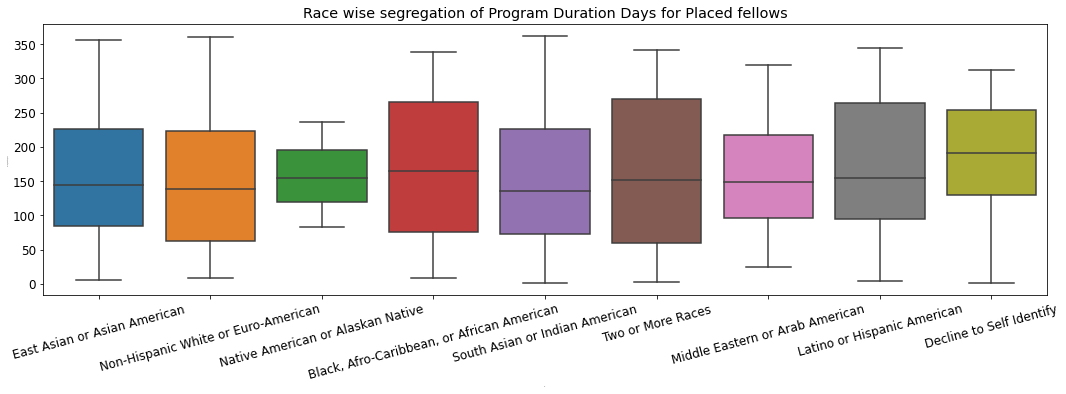

In [446]:
plt.figure(figsize =(18,5))
plt.title('Race wise segregation of Program Duration Days for Placed fellows')
sns.boxplot(y="program_duration_days", x="race", data=pathrise_placed)
plt.xticks(rotation=15)
plt.show()

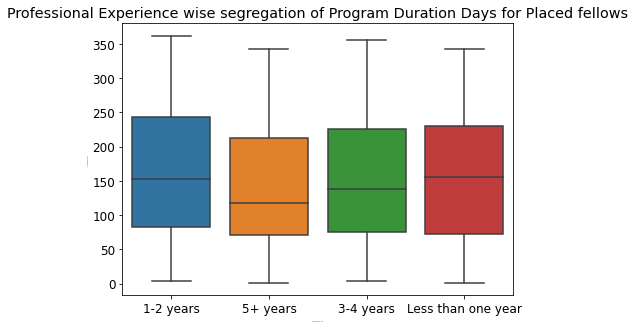

In [447]:
plt.figure(figsize =(7,5))
plt.title('Professional Experience wise segregation of Program Duration Days for Placed fellows')
sns.boxplot(y="program_duration_days", x="professional_experience", data=pathrise_placed)
plt.xticks()
plt.show()

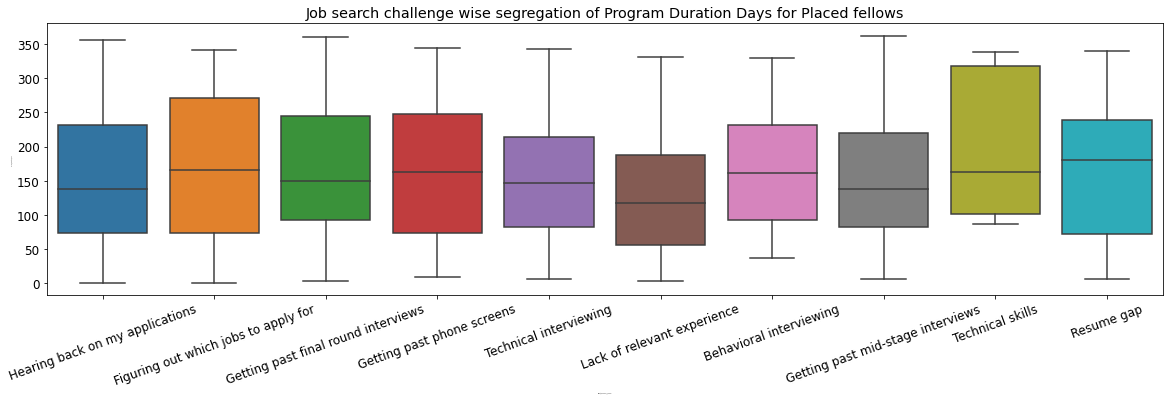

In [448]:
plt.figure(figsize =(20,5))
plt.title('Job search challenge wise segregation of Program Duration Days for Placed fellows')
sns.boxplot(y="program_duration_days", x="biggest_challenge_in_search", data=pathrise_placed)
plt.xticks(rotation=20)
plt.show()

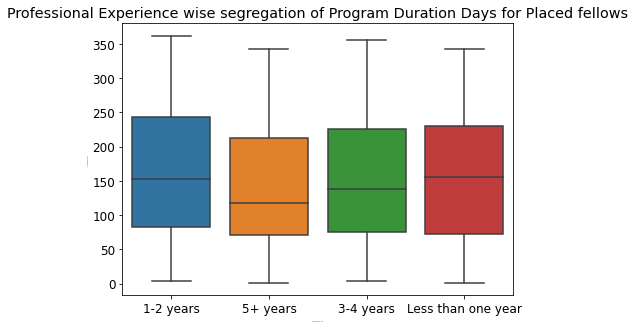

In [449]:
plt.figure(figsize =(7,5))
plt.title('Professional Experience wise segregation of Program Duration Days for Placed fellows')
sns.boxplot(y="program_duration_days", x="professional_experience", data=pathrise_placed)
plt.show()

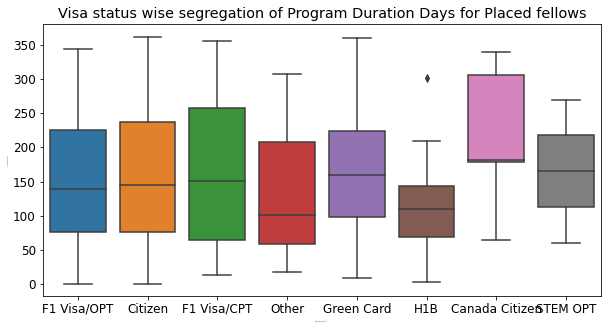

In [450]:
plt.figure(figsize =(10,5))
plt.title('Visa status wise segregation of Program Duration Days for Placed fellows')
sns.boxplot(y="program_duration_days", x="work_authorization_status", data=pathrise_placed)
plt.show()

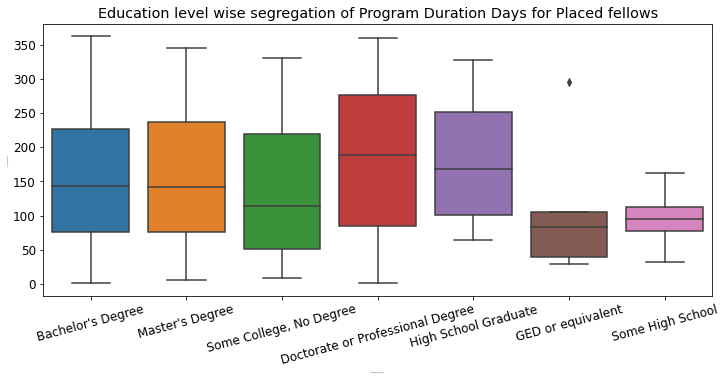

In [451]:
plt.figure(figsize =(12,5))
plt.title('Education level wise segregation of Program Duration Days for Placed fellows')
sns.boxplot(y="program_duration_days", x="highest_level_of_education", data=pathrise_placed)
plt.xticks(rotation=15)
plt.show()

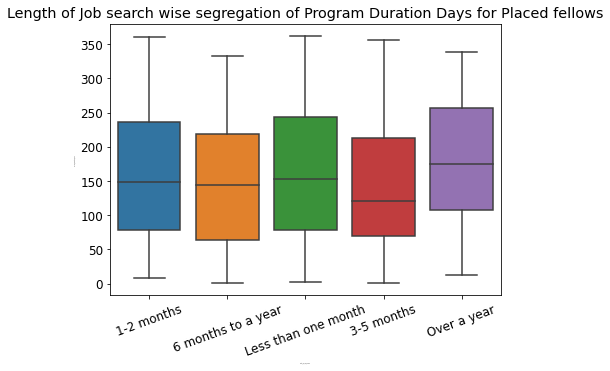

In [452]:
plt.figure(figsize =(7,5))
plt.title('Length of Job search wise segregation of Program Duration Days for Placed fellows')
sns.boxplot(y="program_duration_days", x="length_of_job_search", data=pathrise_placed)
plt.xticks(rotation=20)
plt.show()

I tried solving this as a regression problem, but the values of program_duration_days are randomly scattered. The error rate was very high, so I decided to turn it into a classification problem, by binning it into classes.

In [453]:
bins = [0, 20, 40, 60, 80,100,120,140,160,180,200,220,240,260,280,300,340,365]
pathrise_placed['program_duration_days'] = pd.cut(pathrise_placed['program_duration_days'], bins)

Text(0.5, 1.0, 'Number of interviews vs Program Duration Days')

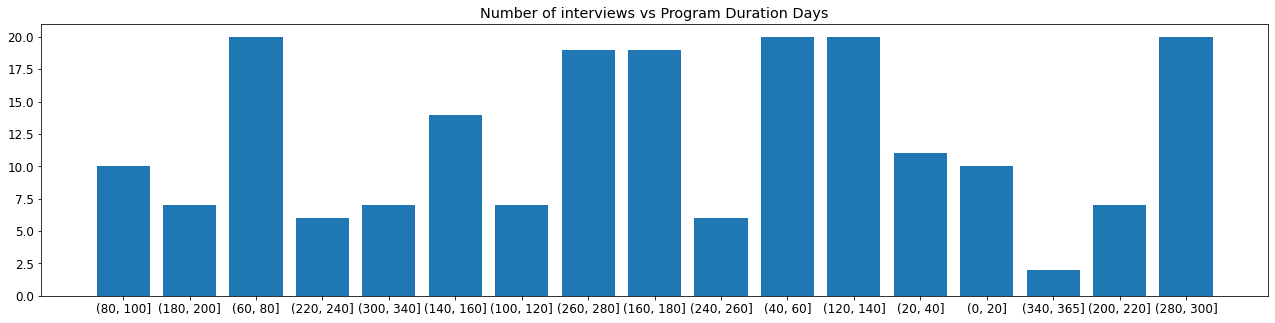

In [454]:
pathrise_placed_=pathrise_placed
pathrise_placed_.program_duration_days=pathrise_placed_.program_duration_days.astype(str)

plt.figure(figsize =(22,5))
plt.bar(pathrise_placed_['program_duration_days'], pathrise_placed_['number_of_interviews'], align='center')
plt.title("Number of interviews vs Program Duration Days")

# Part 2B: Building a model

Just like PART 1B: I use hot encoding to convert the categorical variables into columns

In [455]:
category4=["primary_track","Employment_status","highest_level_of_education","length_of_job_search","biggest_challenge_in_search","professional_experience","work_authorization_status","gender","race"]
pathrise_placed=pd.get_dummies(data=pathrise_placed, columns= category4)

In [456]:
encoder = preprocessing.LabelEncoder()
encoder.fit(pathrise_placed['program_duration_days'])
pathrise_placed['program_duration_days']= encoder.transform(pathrise_placed['program_duration_days'])

In [457]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(pathrise_placed.drop('program_duration_days', 1), pathrise_placed['program_duration_days'], test_size=0.3, random_state=101)#split the dat

# Model 1: Decision Tree Classifier

In [458]:
dtree_model = DecisionTreeClassifier(max_depth = 2,random_state=0).fit(X_train5, y_train5) 
dtree_predictions = dtree_model.predict(X_test5) 
accuracy1 = dtree_model.score(X_test5, y_test5) 
print(accuracy1) 

0.11307420494699646


# Model 2: Naive Bayes classifier

In [459]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB().fit(X_train5, y_train5) 
gnb_predictions = gnb.predict(X_test5) 
  
# accuracy on X_test 
accuracy2 = gnb.score(X_test5, y_test5) 
print(accuracy2)

0.053003533568904596


# Model 3: KNN Classifier

In [460]:
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors = 12).fit(X_train5, y_train5) 
  
# accuracy on X_test 
accuracy3 = knn.score(X_test5, y_test5) 
print(accuracy3) 
knn_predictions = knn.predict(X_test5)  


0.0706713780918728


# Model 4: Support Vector Machine

In [461]:
from sklearn.svm import SVC 
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train5, y_train5) 
svm_predictions = svm_model_linear.predict(X_test5) 
  
# model accuracy for X_test   
accuracy4 = svm_model_linear.score(X_test5, y_test5) 
print(accuracy4)

0.07420494699646643


In [462]:
People_List2 = [[accuracy1],[accuracy2],[accuracy3],[accuracy4]]
Algo=["Decision Tree","Naive Bayes","KNN", "SVM"]
df = DataFrame (People_List2,columns=['Accuracy'])#,'Specificity','Accuracy',"Area under the curve"])
df=df.assign(Algorithm=Algo)
print (df)

   Accuracy      Algorithm
0  0.113074  Decision Tree
1  0.053004    Naive Bayes
2  0.070671            KNN
3  0.074205            SVM


As we can see, SVM is the best classifier with an accuracy of 88% !, So I will use it to test the unseen data of active fellows and predict how much time they will take to get placed based on their data

# PART 2C: Testing on unseen data - fellows who are currently active 

In [463]:
#this is the dataframe which contains fellows who are currently active
pathrise_active.shape

(532, 58)

In [464]:
# this is the dataframe on which I trianed the SVM model
X_train5.shape

(659, 60)

Just like PART 1c, same issues- number of columns are different

In [465]:
common_cols2 = [col for col in set(X_train5.columns).intersection(pathrise_active.columns)]
X_train5=X_train5[common_cols2]
X_test5=X_test5[common_cols2]

Rebuilding the model for new set of columns

In [466]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train5, y_train5) 
svm_predictions = svm_model_linear.predict(X_test5) 
  
# model accuracy for X_test   
accuracy = svm_model_linear.score(X_test5, y_test5) 
print(accuracy)

0.07420494699646643


Finally, the model has been rebuilt, trained, and tested on the seen data, now we test it on fellows who are currently active and predict how much time they will take

In [467]:
y_predict_active_time = svm_model_linear.predict(pathrise_active)
y_predict_active_time

array([13,  9,  5, 13, 13, 13, 13, 13, 13, 13, 13,  8,  5, 13, 13,  8, 13,
       13,  5,  5, 13, 13, 13,  0, 13,  8, 13, 13,  8, 13, 13, 13, 13, 13,
       14, 13, 13, 13, 13, 13,  8, 13, 13, 13, 13,  8, 13, 13,  6, 13, 15,
       13, 13, 13,  8, 13, 13, 13, 13, 13,  5, 13,  5,  5, 13,  8, 13, 13,
       13, 13, 13, 12, 13, 13, 13, 13, 13,  8, 13,  8, 13, 13, 13, 13, 13,
       13,  5, 13, 13, 13, 13, 11,  0,  4, 13,  8, 13, 13,  2, 13,  8, 13,
       13, 13, 13,  8, 13,  8, 13,  8,  5,  0, 13, 13, 13, 13,  0, 13, 13,
        8,  0, 13, 13, 13,  5, 13, 13,  8, 13,  8, 13, 13, 13, 13, 13,  5,
       13, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,  8, 13, 13,  8,  5,
       13, 13, 13,  2, 13,  5, 13, 13, 13, 13,  8, 13, 13,  8, 13,  8, 13,
       13, 13,  0, 13, 13, 13, 13, 13, 13, 13, 13,  5,  5, 13, 13, 13,  8,
       13,  5, 13, 13,  8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13,  5, 14, 13, 13, 13, 13,  8, 13,  8,  8, 13, 14, 13,  8, 13, 13,
       13,  8, 13, 13, 13

If someone wants to know whether a fellow will get placed, they can enter their values corresponding to the columns in the model like gender_male, gender female, visa_status_h1 etc and store it in a list eg: l=[1,0,.....]

Then predict it using the model as below

x=svm_model_linear.predict(l)
x

In [468]:
#_____________________________________________________________________________________________________________

Although not needed by the DATA challenge, further analysis needs to be done to understand why fellows are leaving pathrise after the trial, are declining the offeror are missing in action or deferring.

It will help us understand the root cause issues, and it will reduce our funnel drop off rate and bounce rate, thus leading to improved revenue.